In [137]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model.coxph import BreslowEstimator, CoxPHSurvivalAnalysis
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, make_time_event_split
from tools.model_builder import make_mcd_model
from utility.config import load_config
from utility.loss import CoxPHLoss
import paths as pt
from utility.risk import InputFunction
from tools.model_trainer import Trainer
from tools.model_builder import make_cox_model

DATASET_NAME = "WHAS500"

# Load data
dl = get_data_loader(DATASET_NAME).load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train, valid and test set
X_columns = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Make time/event split
t_train, e_train = make_time_event_split(y_train)
t_test, e_test = make_time_event_split(y_test)

# Make event times
lower, upper = np.percentile(y['time'], [10, 90])
event_times = np.arange(lower, upper+1)

# Create Cox model
cox_config = load_config(pt.COX_CONFIGS_DIR, f"{DATASET_NAME.lower()}.yaml")
model = make_cox_model(cox_config)
model.fit(X_train, y_train)

# Select only test samples where event occurs
#test_idx = list(np.where(y_test['event'] == True)[0])
#X_test = X_test[test_idx]
#y_test = y_test[test_idx]

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


CoxPHSurvivalAnalysis(alpha=0.0001)

In [138]:
# Compute surv func
test_sample = X_test
test_surv_fn = model.predict_survival_function(test_sample)
surv_preds = np.row_stack([fn(event_times) for fn in test_surv_fn])
surv_preds

array([[0.9156167 , 0.91303064, 0.91303064, ..., 0.39149048, 0.39149048,
        0.39149048],
       [0.95203155, 0.95053126, 0.95053126, ..., 0.59278741, 0.59278741,
        0.59278741],
       [0.97702232, 0.97629393, 0.97629393, ..., 0.7809204 , 0.7809204 ,
        0.7809204 ],
       ...,
       [0.96319351, 0.96203534, 0.96203534, ..., 0.67104142, 0.67104142,
        0.67104142],
       [0.69063255, 0.68247939, 0.68247939, ..., 0.01949644, 0.01949644,
        0.01949644],
       [0.83761692, 0.83286858, 0.83286858, ..., 0.15183752, 0.15183752,
        0.15183752]])

In [139]:
# Plot surv funcs
'''
styles = ('-', '--')
plt.figure(dpi=80)
for i, surv_fn in enumerate(test_surv_fn):
    plt.step(event_times, surv_fn(event_times), where="post", label=str(i))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$")
plt.grid(True)
plt.show()
'''

'\nstyles = (\'-\', \'--\')\nplt.figure(dpi=80)\nfor i, surv_fn in enumerate(test_surv_fn):\n    plt.step(event_times, surv_fn(event_times), where="post", label=str(i))\nplt.legend(loc=\'upper center\', bbox_to_anchor=(0.5, 1.05),\n          ncol=5, fancybox=True, shadow=True)\nplt.ylabel("Probability of survival $S(t)$")\nplt.xlabel("Time $t$")\nplt.grid(True)\nplt.show()\n'

In [140]:
from scipy.integrate import trapezoid
def compute_survival_times(risk_scores, t_train, e_train, seed):
    # https://pubmed.ncbi.nlm.nih.gov/15724232/
    rnd = np.random.RandomState(seed)

    # generate survival time
    mean_survival_time = t_train[e_train].mean()
    baseline_hazard = 1. / mean_survival_time
    scale = baseline_hazard * np.exp(risk_scores)
    u = rnd.uniform(low=0, high=1, size=risk_scores.shape[0])
    t = -np.log(u) / scale

    return t

def trapz_wrapper(X):
    """Helper function
    TBC
    """
    # NOTE: y - values | x - index
    return trapezoid(X.y, X.x)

trapz_times = np.array(list(map(trapz_wrapper, test_surv_fn)))

In [141]:
risk_scores = model.predict(test_sample)
samples = list()
for i in range(0, 500): # sample 500 times
    samples.append(compute_survival_times(risk_scores, t_train, e_train, i))
simulated_times = np.mean(samples, axis=0)
simulated_times

array([ 238.41711476,  410.209593  ,  913.11712299,  161.39150313,
       2223.16338375,  758.03200934,  691.44040577,  667.96319412,
        126.65161194, 1251.90391727,  330.86148893,   33.68291474,
        346.24275983,  964.58886895,  294.05400815,  228.78191824,
        703.13783267, 1128.73343858,  341.72072959,   93.45853817,
         21.46982797, 1735.66931554,  138.89646924,  380.37284109,
        530.28533612, 1301.48128872,  193.55697857, 1821.73489269,
        497.74716423,  276.66482876,  895.64770721,  340.03787897,
        343.09858488,  236.48061703, 1010.05777052,   38.70029825,
       2611.26861261,  109.58739491,   37.18861639,  211.23815185,
        284.08155472,  104.35098433,  466.33347076,   59.03048716,
       1356.65577625,  851.85117546,   48.94771913,  252.82941342,
        141.75080222,  399.66152966, 1285.55548672,  683.5800713 ,
        110.71677467, 1080.22447466,  285.78528344, 1812.31782847,
        382.32606552,  467.42180281,  133.9129222 ,  748.50407

In [142]:
from typing import Union
import pandas as pd

def qth_survival_time(q: float, model_or_survival_function) -> float:
    """
    Returns the time when a single survival function reaches the qth percentile, that is,
    solves  :math:`q = S(t)` for :math:`t`.

    Parameters
    ----------
    q: float
      value between 0 and 1.
    model_or_survival_function: Series, single-column DataFrame, or lifelines model


    See Also
    --------
    qth_survival_times, median_survival_times
    """
    from lifelines.fitters import UnivariateFitter

    if isinstance(model_or_survival_function, UnivariateFitter):
        return model_or_survival_function.percentile(q)
    elif isinstance(model_or_survival_function, pd.DataFrame):
        if model_or_survival_function.shape[1] > 1:
            raise ValueError(
                "Expecting a DataFrame (or Series) with a single column. Provide that or use utils.qth_survival_times."
            )
        return qth_survival_time(q, model_or_survival_function.T.squeeze())
    elif isinstance(model_or_survival_function, pd.Series):
        if model_or_survival_function.iloc[-1] > q:
            return np.inf
        return model_or_survival_function.index[(-model_or_survival_function).searchsorted([-q])[0]]
    else:
        raise ValueError(
            "Unable to compute median of object %s - should be a DataFrame, Series or lifelines univariate model"
            % model_or_survival_function
        )

def _to_1d_array(x) -> np.ndarray:
    v = np.atleast_1d(x)
    try:
        if v.shape[0] > 1 and v.shape[1] > 1:
            raise ValueError("Wrong shape (2d) given to _to_1d_array")
    except IndexError:
        pass
    return v

def qth_survival_times(q, survival_functions) -> Union[pd.DataFrame, float]:
    """
    Find the times when one or more survival functions reach the qth percentile.

    Parameters
    ----------
    q: float or array
      a float between 0 and 1 that represents the time when the survival function hits the qth percentile.
    survival_functions: a (n,d) DataFrame, Series, or NumPy array.
      If DataFrame or Series, will return index values (actual times)
      If NumPy array, will return indices.

    Returns
    -------
    float, or DataFrame
         if d==1, returns a float, np.inf if infinity.
         if d > 1, an DataFrame containing the first times the value was crossed.

    See Also
    --------
    qth_survival_time, median_survival_times
    """
    # pylint: disable=cell-var-from-loop,misplaced-comparison-constant,no-else-return
    q = _to_1d_array(q)
    q = pd.Series(q.reshape(q.size), dtype=float)

    if not ((q <= 1).all() and (0 <= q).all()):
        raise ValueError("q must be between 0 and 1")

    survival_functions = pd.DataFrame(survival_functions)

    if survival_functions.shape[1] == 1 and q.shape == (1,):
        q = q[0]
        # If you add print statements to `qth_survival_time`, you'll see it's called
        # once too many times. This is expected Pandas behavior
        # https://stackoverflow.com/questions/21635915/why-does-pandas-apply-calculate-twice
        return survival_functions.apply(lambda s: qth_survival_time(q, s)).iloc[0]
    else:
        d = {_q: survival_functions.apply(lambda s: qth_survival_time(_q, s)) for _q in q}
        survival_times = pd.DataFrame(d).T
        #  Typically, one would expect that the output should equal the "height" of q.
        #  An issue can arise if the Series q contains duplicate values. We solve
        #  this by duplicating the entire row.
        if q.duplicated().any():
            survival_times = survival_times.loc[q]

        return survival_times

In [143]:
#test_surv_fn = model.predict_survival_function(test_sample)
#surv_preds = np.row_stack([fn(event_times) for fn in test_surv_fn])

In [144]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.0001)
data = pd.concat([pd.DataFrame(X_train),
                  pd.Series(y_train['time'], name="Survival_time"),
                  pd.Series(y_train['event'], name="Event")], axis=1)
cph.fit(data, duration_col="Survival_time", event_col="Event")

iteritems is deprecated and will be removed in a future version. Use .items instead.
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


<lifelines.CoxPHFitter: fitted with 350 total observations, 187 right-censored observations>

In [145]:
lifelines_trapz_times = cph.predict_expectation(test_sample)

In [146]:
lifelines_median_times = cph.predict_median(test_sample)

In [147]:
lifelines_percentile_times = cph.predict_percentile(test_sample, 0.95)

In [148]:
real_times = y_test['time']

In [149]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

max_time = np.max(y['time'])
res = pd.DataFrame([real_times, trapz_times, simulated_times, lifelines_trapz_times,
                    lifelines_median_times,lifelines_percentile_times]).T
res.columns = ['Real', 'Trapz', 'Sim', 'LL-Trapz', 'LL-Med', 'LL-Per']
res['LL-Med'].replace([np.inf, -np.inf], max_time, inplace=True)
res['LL-Per'].replace([np.inf, -np.inf], max_time, inplace=True)

In [150]:
print("MSE")
print(mean_squared_error(res['Real'], res['Trapz']))
print(mean_squared_error(res['Real'], res['Sim']))
print(mean_squared_error(res['Real'], res['LL-Trapz']))
print(mean_squared_error(res['Real'], res['LL-Per']))
print()
print("MAE")
print(mean_absolute_error(res['Real'], res['Trapz']))
print(mean_absolute_error(res['Real'], res['Sim']))
print(mean_absolute_error(res['Real'], res['LL-Trapz']))
print(mean_absolute_error(res['Real'], res['LL-Per']))


MSE
725969.7949707264
785674.1766597684
728394.1701078353
1201465.1533333333

MAE
658.157498184027
685.8106515307535
658.6007789708709
865.8733333333333


ICI =  0.050871662362079836
E50 =  0.04110479159319874


divide by zero encountered in log


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 25 mortality'}, xlabel='Predicted probability of \nt ≤ 25 mortality', ylabel='Observed probability of \nt ≤ 25 mortality'>,
 0.050871662362079836,
 0.04110479159319874)

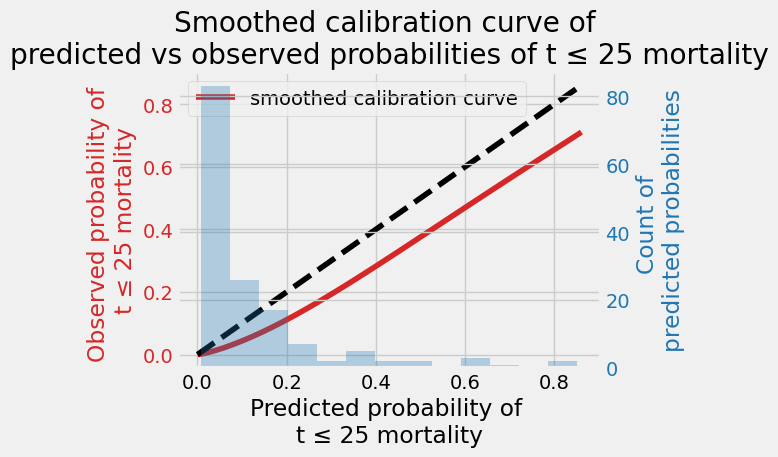

In [151]:
from lifelines.calibration import survival_probability_calibration

data = pd.concat([pd.DataFrame(X_test),
                  pd.Series(y_test['time'], name="Survival_time"),
                  pd.Series(y_test['event'], name="Event")], axis=1)

survival_probability_calibration(cph, data, t0=25)